# Modified Davies-Bouldin Index

The Davies-Bouldin Index (DBI) is a clustering evaluation metric that measures the compactness and separation of clusters.
It is calculated using:

$$DBI = \frac{1}{k} \sum_{i=1}^{k} \max_{i \neq j} \left(\frac{s_i + s_j}{d_{ij}}\right)$$

where $k$ is the number of clusters, $s_i$ and $s_j$ are the average intra-cluster distances, and $d_{ij}$ is the centroid distance between clusters $i$ and $j$. Smaller DBI values indicate better clustering.

To normalize the DBI to the range $[0, 1]$, divide it by a maximum value, which depends on the dataset and clustering algorithm. One approach is to use the maximum DBI obtained from random or baseline clusterings:

* Calculate the DBI for the original clustering.
* Generate random or baseline clusterings, and compute their DBIs.
* Find the maximum DBI value from the random clusterings, $DBI_{max}$.
* Normalize the original DBI by dividing it by $DBI_{max}$:

$$DBI_{norm} = \frac{DBI}{DBI_{max}}$$

 
The resulting normalized DBI, $DBI_{norm}$, will have a value in the range [0, 1]. Values closer to 0 indicate better clustering quality compared to the random or baseline clustering results.

Keep in mind that this normalization is based on a comparison to random or baseline clustering results and may not be suitable for all situations. The quality of the normalization depends on the appropriateness of the random or baseline clustering methods used.

In [ ]:
from online_hui_walter.latent_structure_analysis import latent_profiles
from online_hui_walter.rolling_metrics import get_marginals, alpha1, alpha2, beta1, beta2
from river import stream
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from sklearn import datasets
from sklearn.linear_model import LogisticRegression


from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from river import compose
from river import compat

import numpy as np
from sklearn.mixture import GaussianMixture

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = datasets.load_breast_cancer()

feat1 = [
    'mean radius',
    'mean texture',
]
feat2 = [
    'mean concavity',
    'mean symmetry'
]

df = pd.read_csv("latent_class_breast_cancer.csv")

#df_sample = df.sample(200, random_state=1)
y = data['target']  
X = data['data']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)
selected_features = [list(data['feature_names']).index(x) for x in feat1]
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
clf1 = svm.SVC(random_state=0).fit(X_train_sel, y_train)
y_pred = clf1.predict(X_test_sel)
print(classification_report(
    y_test,
    y_pred,
    target_names=["Benign", "Malicious"]))

cm = confusion_matrix(y_test, y_pred)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print(FPR, FNR)
fpr1 = FPR
fnr1 = FNR

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=0)
selected_features = [list(data['feature_names']).index(x) for x in feat2]
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
clf2 =  RandomForestClassifier(max_depth=2, random_state=0).fit(X_train_sel, y_train)
y_pred = clf2.predict(X_test_sel)
print(classification_report(
    y_test,
    y_pred,
    target_names=["Benign", "Malicious"]
))

cm = confusion_matrix(y_test, y_pred)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print(FPR, FNR)
fpr2 = FPR
fnr2 = FNR

              precision    recall  f1-score   support

      Benign       0.88      0.82      0.85        98
   Malicious       0.91      0.94      0.92       187

    accuracy                           0.90       285
   macro avg       0.89      0.88      0.89       285
weighted avg       0.90      0.90      0.90       285

0.1836734693877551 0.058823529411764705
              precision    recall  f1-score   support

      Benign       0.83      0.77      0.80       101
   Malicious       0.88      0.91      0.90       184

    accuracy                           0.86       285
   macro avg       0.85      0.84      0.85       285
weighted avg       0.86      0.86      0.86       285

0.22772277227722773 0.08695652173913043


In [ ]:
# Latent Profile Analysis
gmm = GaussianMixture(n_components=2, random_state=0)
history = []
profiles = []
predictions = []
svm_preds = []
rf_preds = []

for i, sample in enumerate(stream.iter_sklearn_dataset(datasets.load_breast_cancer(), shuffle=True, seed=42)):
    xi, yi = sample
    sample1 = [xi[x] for x in feat1]
    sample2 = [xi[x] for x in feat2]
    history.append([xi[x] for x in feat1 + feat2])
    if i >= 5:
        profiles.append(gmm.fit_predict(np.asarray(history)))
    svm_preds.append((sample1, clf1.predict([sample1])))
    rf_preds.append((sample2, clf2.predict([sample2])))
    predictions.append([clf1.predict([sample1]), clf2.predict([sample2]), yi])


In [ ]:
def table(profiles, predictions):

    t = np.zeros((2,2,2))
    for i, prediction in enumerate(predictions):
        pop = profiles[i]
        t1, t2, t_true = prediction
        t1 = t1[0]
        t2 = t2[0]
        if t1 == 1 and t2 == 1:
            t[0,0,pop] += 1
        if t1 == 1 and t2 == 0:
            t[0,1,pop] += 1
        if t1 == 0 and t2 == 1:
            t[1,0,pop] += 1
        if t1 == 0 and t2 == 0:
            t[1,1,pop] += 1
    return t

def get_marginals(table):
    output = []
    if table.shape != (2, 2, 2):
        raise Exception("More than two pops or tests, not implemented.")
    for i in range(2):
        colsums = table[:,:,i].sum(axis=1)
        rowsums = table[:,:,i].sum(axis=0)
        n = np.concatenate(t[:,:,i]).sum()
        flattened = t[:,:,i].ravel()
        # a, b, c, d, e, f, g, h, n
        output.append(list(flattened) + list(colsums) + list(rowsums) + [n])
    return output

def beta1(d1, d2, e1, e2, g1, g2, n1, n2, F):
    numerator = (g1*e2-e1*g2)/(n1*n2) - d1/n1  + d2/n2 - F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator

def beta2(d1, d2, e1, e2, g1, g2, n1, n2, F):
    numerator = (g2*e1 - e2* g1)/(n1*n2) - d1/n1 + d2/n2 - F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator


def alpha1(a1, a2, e1, e2, f1, f2, h1, h2, n1, n2, F):
    numerator = (f1 * h2 - h1 * f2)/(n1 * n2) + a2/n2 - a1/n1 + F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator

def alpha2(a1, a2, g1, g2, f1, f2, h1, h2, n1, n2, F):
    numerator = (f2*h1-h2*f1)/(n1*n2) + a2/n2 - a1/n1 - F
    denominator = 2 * (g2/n2 - g1/n1)
    return numerator/denominator


def get_F(a1, a2, e1, e2, g1, g2, n1, n2):
    b = (g1 * e2 - g2 * e1)/ (n1*n2) + a1/n2 - a2/n2
    a = (g1/n1 - g2/n2)
    c = (a1 * e2 - a2 * e1) / (n1 * n2)
    return np.sqrt(b**2 - 4 * a * c)

def get_theta(x, a1, a2, e1, e2, g1, g2, n1, n2, F):
    a = (e1/n1 - e2/n2)
    b = (g1/n1 - g2/n2)
    c = a2/n2 - a1/n1
    return 1/2 - (x * a + x * b + c)/(2*F)

def get_metrics(table):
    pop1, pop2 = get_marginals(table)
    # a, b, c, d, e, f, g, h, n
    a1, b1, c1, d1, e1, f1, g1, h1, n1 = pop1
    a2, b2, c2, d2, e2, f2, g2, h2, n2 = pop2
    # a1, b1, c1, d1, g1, h1, e1, f1, n1 = pop1
    # a2, b2, c2, d2, g2, h2, e2, f2, n2 = pop2
    F = get_F(a1, a2, e1, e2, g1, g2, n1, n2)
    theta1 = get_theta(g1/n1, a1, a2, e1, e2, g1, g2, n1, n2, F)
    theta2 = get_theta(g2/n2, a1, a2, e1, e2, g1, g2, n1, n2, F)
    b1 = beta1(d1, d2, e1, e2, g1, g2, n1, n2, F)
    b2 = beta2(d1, d2, e1, e2, g1, g2, n1, n2, F)
    a1 = alpha1(a1, a2, e1, e2, f1, f2, h1, h2, n1, n2, F)
    a2 = alpha2(a1, a2, g1, g2, f1, f2, h1, h2, n1, n2, F)
    return theta1, theta2, a1, a2, b1, b2

ts = []
for i in range(len(predictions)):
    t = table(profiles[-1], predictions[:i])
    get_metrics(t)
    ts.append(get_metrics(t))


In [48]:
# Bootstrap to get the upper bound of a random clustering for model 1
from sklearn.metrics import davies_bouldin_score

n_bootstraps = 999
bootstrap_davie_boudin = []
for i in range(n_bootstraps):
    X = [x[0] for x in svm_preds]
    num_data_points = len(svm_preds)  # Set this to the number of data points in your dataset
    labels = np.random.choice([0, 1], size=num_data_points)
    bootstrap_davie_boudin.append(davies_bouldin_score(X, labels))

#upper_rf = np.percentile(bootstrap_davies_boudin, [0, 97.5])[1]
upper_rf = np.mean(bootstrap_davies_boudin)
X = [x[0] for x in svm_preds]
labels = [x[1] for x in svm_preds]
1 - davies_bouldin_score(X, labels)/upper_svm

0.9920967073867245

In [49]:
n_bootstraps = 999
bootstrap_davies_boudin = []
for i in range(n_bootstraps):
    X = [x[0] for x in svm_preds]
    num_data_points = len(svm_preds)  # Set this to the number of data points in your dataset
    labels = np.random.choice([0, 1], size=num_data_points)
    bootstrap_davies_boudin.append(davies_bouldin_score(X, labels))

#upper_svm = np.percentile(bootstrap_davies_boudin, [0, 97.5])[1]
upper_rf = np.mean(bootstrap_davies_boudin)
X = [x[0] for x in rf_preds]
labels = [x[1] for x in rf_preds]
1 - davies_bouldin_score(X, labels)/upper_rf

0.9821203974742827

ba1 (0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0)
ba2 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0)


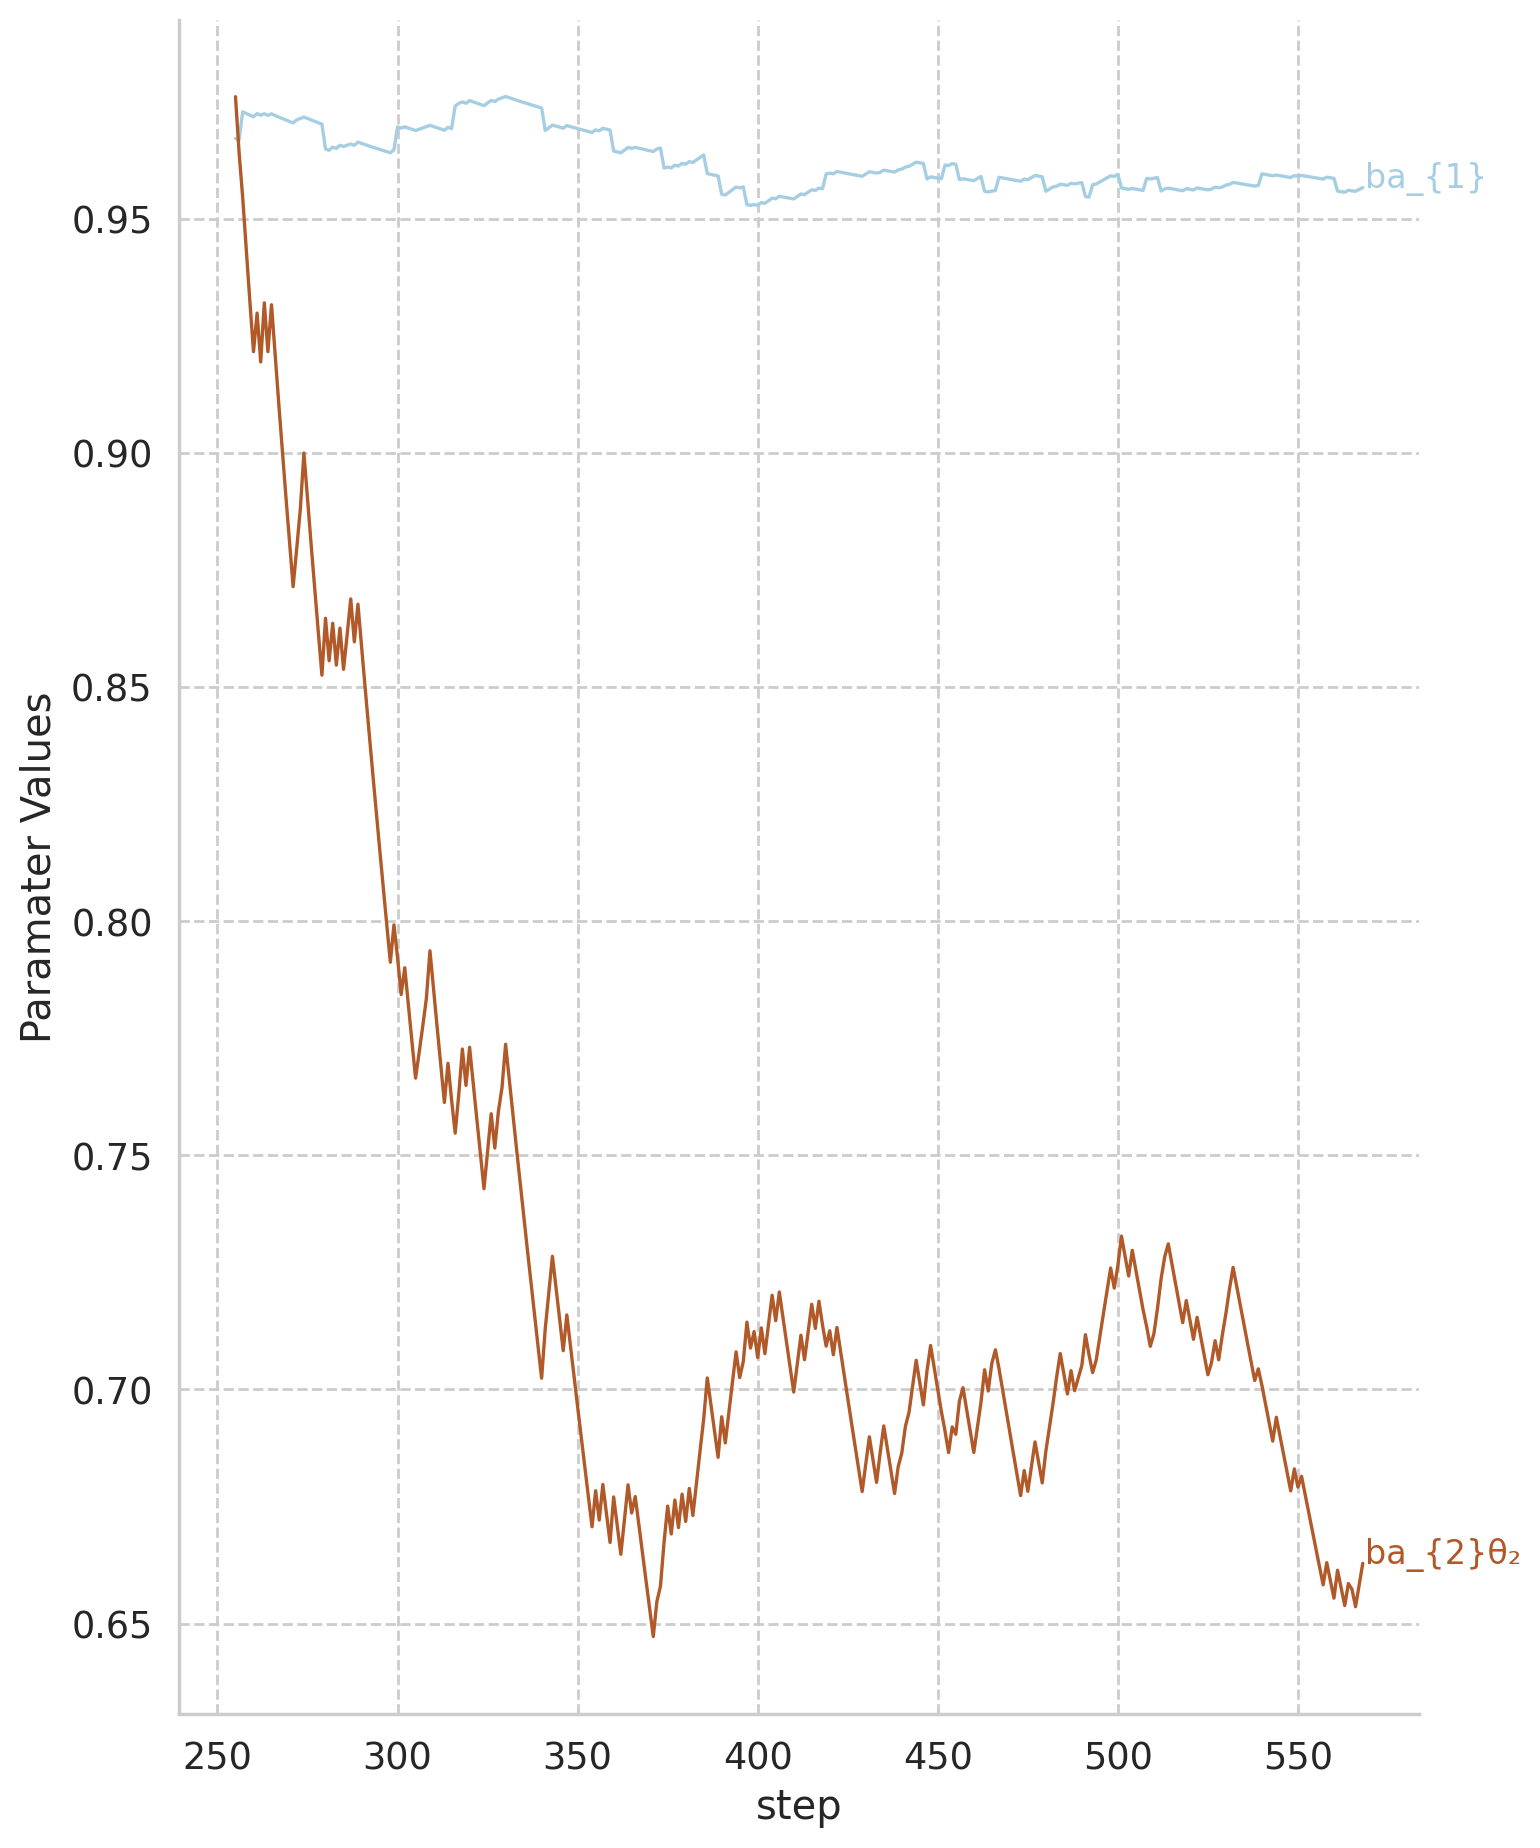

In [63]:

k = 255
theta1_timeseries = [t[0] if t[0] != np.nan else 0 for t in ts][k:]
theta2_timeseries = [t[1] if t[1] != np.nan else 0 for t in ts][k:]

alpha1_timeseries = [t[2] if t[2] != np.nan else 0 for t in ts][k:]
alpha2_timeseries = [t[3] if t[3] != np.nan else 0 for t in ts][k:]

beta1_timeseries = [t[4] if t[4] != np.nan else 0 for t in ts][k:]
beta2_timeseries = [t[5] if t[5] != np.nan else 0 for t in ts][k:]

tpr1 = (1 - np.asarray(alpha1_timeseries))
tpr2 = (1 - np.asarray(alpha2_timeseries))
tnr1 = (1 - np.asarray(beta1_timeseries))
tnr2 = (1 - np.asarray(beta2_timeseries))

ba1 = (tpr1 + tnr1)/2
ba2 = (tpr2 + tnr2)/2


df = pd.DataFrame(
    {
        "step": [i for i in range(len(ts))][k:],
        "theta1": theta1_timeseries,
        "theta2": theta2_timeseries,
        "alpha1": alpha1_timeseries,
        "alpha2": alpha2_timeseries,
        "beta1": beta1_timeseries,
        "beta2": beta2_timeseries,
        "ba1" : ba1,
        "ba2" : ba2
    }
)

def legend_positions(df, y):
    """ Calculate position of labels to the right in plot... """
    positions = {}
    for column in y:    
        positions[column] = df[column].values[-1]  #- 1.5    

    def push():
        """
        ...by puting them to the last y value and
        pushing until no overlap
        """
        collisions = 0
        for column1, value1 in positions.items():
            for column2, value2 in positions.items():
                if column1 != column2:
                    dist = abs(value1-value2)
                    if dist < 0.02:
                        collisions += 1
                        if value1 < value2:
                            positions[column1] -= .01
                            positions[column2] += .01
                        else:
                            positions[column1] += .01
                            positions[column2] -= .01
                        return True
    while True:
        pushed = push()
        if not pushed:
            break

    return positions

x = 'step'
#y = ['theta1', 'theta2', 'alpha1',
#      'alpha2', 'beta1', 'beta2']
y = ["ba1", "ba2"]
leg = [
    #"$\theta_1$", "$\theta_1$", "$\alpha_1$", "$\alpha_2$", "$\beta_1$", "$\beta_2$"
    "ba_{1}",
    "ba_{2}"
    "θ₂",
    "θ₁",
    "α₁",
    "α₂",
    "β₁",
    "β₂",
]
positions = legend_positions(df, y)

f, ax = plt.subplots(figsize=(8,11))        
cmap = plt.cm.get_cmap('Paired', len(y))

for i, (column, position) in enumerate(positions.items()):

    # Get a color
    color = cmap(float(i)/len(positions))
    # Plot each line separatly so we can be explicit about color
    ax = df.plot(x=x, y=column, legend=False, ax=ax, color=color)

    
    print(y[i], color)
    # Add the text to the right
    plt.text(
        df[x][df[column].last_valid_index()] + 0.5,
        position, leg[i], fontsize=12,
        color=color # Same color as line
    )

# Thetas

ax.set_ylabel('Paramater Values')
sns.despine()

# Balanced Accuracy for both models


In [66]:
print(np.mean(ba1))
print(np.mean(ba2))

0.9623405937485009
0.730408327848909


In [65]:
from sklearn.metrics import mean_absolute_error as mae

#calculate MAE

print(mae(theta1_timeseries[200:], [0.11] * len(theta1_timeseries[200:])))
print(mae(theta2_timeseries[200:], [0.514] * len(theta2_timeseries[200:])))

print(mae(alpha1_timeseries[200:], [fpr1] * len(alpha1_timeseries[200:])))
print(mae(alpha2_timeseries[200:], [fpr2] * len(alpha2_timeseries[200:])))

print(mae(beta1_timeseries[200:], [fnr1] * len(beta1_timeseries[200:])))
print(mae(beta2_timeseries[200:], [fnr2] * len(beta2_timeseries[200:])))

0.012236318604235828
0.32531162995818486
0.13443621807975883
0.17952307262921688
0.027768639944947705
0.10920177327157642
